In [21]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt 

### Hand detection

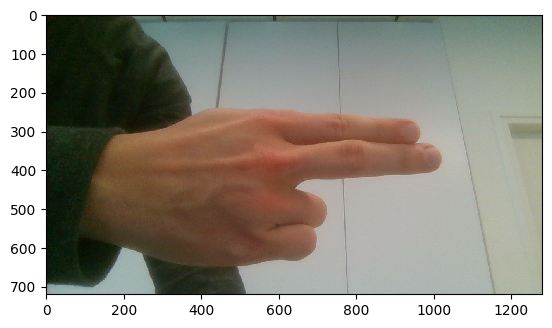

In [27]:
img = cv2.imread('data/segmentation/H_proche.jpg',1)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb,interpolation='nearest')
plt.show()

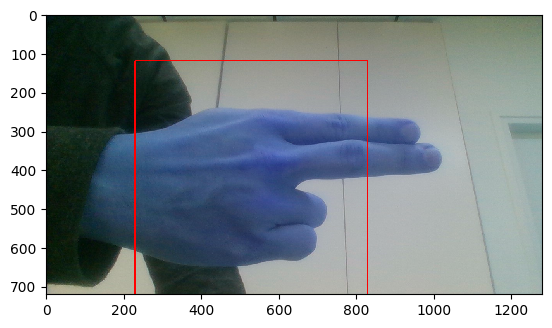

In [28]:
x, y, w, h = 100, 100, 600, 600 # simply hardcoded the values
track_window = (x, y, w, h)

roi = img[y:y+h, x:x+w]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 1 )
ret, track_window = cv2.meanShift(dst, track_window,term_crit)

x,y,w,h = track_window
img2 = cv2.rectangle(img, (x,y), (x+w,y+h), 255,2)
plt.imshow(img2,interpolation='nearest')

# we could first segment the position of the hand by constraining its position on the photo and then only try to get interest points



### contrast

In [30]:
img1 = cv2.imread('data/B_real2.jpg',1)  
img2 = cv2.imread('data/labels/F.jpg',1) 

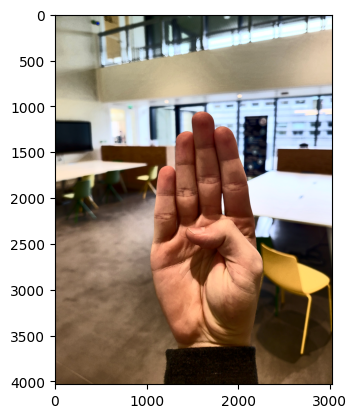

In [20]:
def equalize(img):
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_channel_equalized = cv2.equalizeHist(l_channel)
    lab_image_equalized = cv2.merge((l_channel_equalized, a_channel, b_channel))
    output_image = cv2.cvtColor(lab_image_equalized, cv2.COLOR_LAB2RGB)
    return output_image

plt.imshow(equalize(img1))
# plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))


### reduce image quality

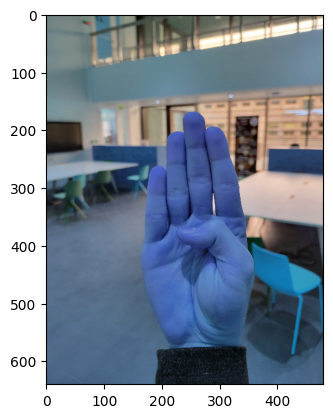

In [49]:
img1 = cv2.imread('data/B_real2.jpg',1)  
img2 = cv2.imread('data/labels/F.jpg',1)

def resize_to_max(img, max_size_value = 640):
    max_size = max(img.shape[0], img.shape[1])
    ratio = max_size_value/max_size
    target_resolution = (int(img.shape[1]*ratio),int(img.shape[0]*ratio))
    resized_image = cv2.resize(img, target_resolution)
    return resized_image

resized_image = resize_to_max(img1)
plt.imshow(resized_image)

### matching

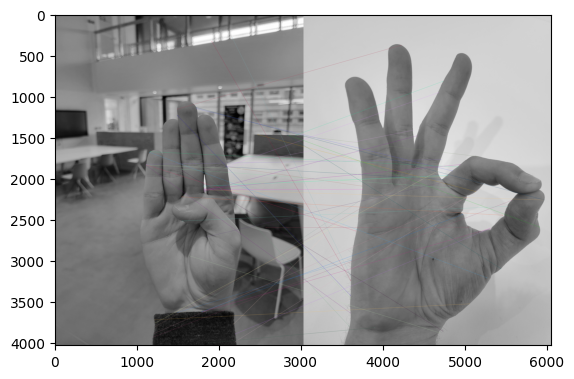

(<matplotlib.image.AxesImage at 0x1dcc65981d0>, None)

In [36]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.SIFT_create()


keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

In [53]:
def classify(img_path,labels_directory):
    
    liste_len_matching = {}
    sift = cv2.SIFT_create() # we could also use ORB but I dont think it work better
    bf = cv2.BFMatcher(crossCheck=True) # we can specify another norm than L2


    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints_1, descriptors_1 = sift.detectAndCompute(img,None)

    for filename in os.listdir(labels_directory):
        img_path = os.path.join(labels_directory, filename)
        img_label = cv2.imread(img_path)
        img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2GRAY)
        keypoints_2, descriptors_2 = sift.detectAndCompute(img_label,None)
        liste_len_matching[filename] = len(bf.match(descriptors_1,descriptors_2))
    chosen = max(liste_len_matching, key=lambda k: liste_len_matching[k])
    return chosen, liste_len_matching

In [54]:
chosen,liste_len_matching = classify('data/F_real.jpg','data/labels/')

In [41]:
chosen

'F.jpg'

In [42]:
liste_len_matching

{'A.jpg': 57,
 'B.jpg': 125,
 'C.jpg': 93,
 'D.jpg': 114,
 'E.jpg': 70,
 'F.jpg': 153}